In [48]:
import numpy as np
import pandas as pd

from fbprophet import Prophet
from datetime import date, timedelta

import matplotlib.pyplot as plt
# from DataLoader import *

In [2]:
data_path = "../../WHAI-provided_data/"

In [3]:
p_path = data_path+"02_picking-activity_K1.csv"

def preprocessing(picking_path=p_path):
    picking = pd.read_csv(picking_path)
    picking["Execution_time"] = pd.to_datetime(picking["Execution_time"])
    return picking

In [4]:
picking = preprocessing(p_path)

In [5]:
len(sorted(picking.Artikelno.unique()))

620

### Generate Sundays

In [6]:
from datetime import date, timedelta

def Sunday(years=(2018,2025)):
    year_low,year_up = years
    
    def findsundays(year):
        d = date(year, 1, 1)                    # January 1st
        d += timedelta(days = 6 - d.weekday())  # First Sunday
        while d.year == year:
            yield d
            d += timedelta(days = 7)


    sun = []
    for y in range(year_low,year_up):
        for d in findsundays(y):
            sun.append(d)
    
    sundays = pd.DataFrame({
      'holiday': 'Sunday',
      'ds': sun,
      'lower_window': 0,
      'upper_window': 0,
    })
    return sundays

In [7]:
timedelta

datetime.timedelta

In [8]:
(picking["Execution_time"].max()-picking["Execution_time"].min()).days

700

## Picking Simulator

In [9]:
pd.date_range(end ='2020-07-31', periods = 700, freq='D')

DatetimeIndex(['2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05', '2018-09-06', '2018-09-07', '2018-09-08',
               '2018-09-09', '2018-09-10',
               ...
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', length=700, freq='D')

In [10]:
def Simulator(artikelno,freq = "D", periods = 365, years=(2018,2025)):
    DateRange = pd.DataFrame({"Execution_time":pd.date_range('2018-08-31', periods = 701, freq='D')})
    picking_artikel = picking[picking["Artikelno"]==artikelno]
    
    picking_sum = picking_artikel.groupby(["Execution_time"],as_index = 0)["Amount"].sum()
    picking_ts = DateRange.merge(picking_sum,on = "Execution_time", how = "left")
    picking_ts["Amount"] = picking_ts["Amount"]
    
    if isinstance(years,tuple):
        sundays = Sunday(years)
    elif isinstance(years,int):
        sundays = Sunday((2018,years))
    else: raise KeyError("Parameter 'years' should be an int or tuple.")

    picking_ts.columns =  ["ds","y"]
    m = Prophet(holidays = sundays,yearly_seasonality=True,daily_seasonality=True)
    m.add_country_holidays(country_name='US')
    m.fit(picking_ts)
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    
    return m, forecast
    

In [11]:
model, forecast = Simulator(142)

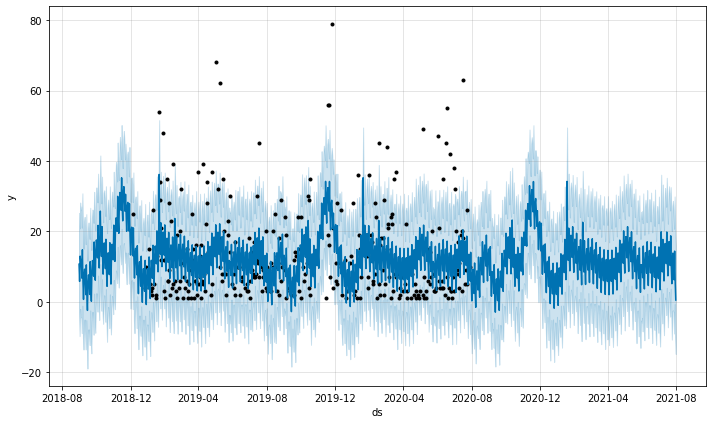

In [12]:
fig1 = model.plot(forecast)

In [13]:
a = 10
fig1.savefig("forecast_%s.png" % a)

In [14]:
forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-31,22.662362,-3.129549,25.178588,22.662362,22.662362,0.0,0.0,0.0,0.0,...,-2.207799,-2.207799,-2.207799,0.048223,0.048223,0.048223,0.0,0.0,0.0,10.683830
1,2018-09-01,22.660949,-9.749685,20.818427,22.660949,22.660949,0.0,0.0,0.0,0.0,...,-6.565659,-6.565659,-6.565659,-0.484552,-0.484552,-0.484552,0.0,0.0,0.0,5.791781
2,2018-09-02,22.659535,-2.077381,28.186398,22.659535,22.659535,0.0,0.0,0.0,0.0,...,1.227370,1.227370,1.227370,-1.099521,-1.099521,-1.099521,0.0,0.0,0.0,12.968427
3,2018-09-03,22.658122,-4.429649,26.022404,22.658122,22.658122,0.0,0.0,0.0,0.0,...,3.376182,3.376182,3.376182,-1.782105,-1.782105,-1.782105,0.0,0.0,0.0,11.464212
4,2018-09-04,22.656708,-4.461935,27.032246,22.656708,22.656708,0.0,0.0,0.0,0.0,...,1.000104,1.000104,1.000104,-2.515826,-2.515826,-2.515826,0.0,0.0,0.0,11.322029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,2021-07-27,21.162545,-2.924275,25.284122,21.162542,21.162547,0.0,0.0,0.0,0.0,...,1.000104,1.000104,1.000104,-1.567758,-1.567758,-1.567758,0.0,0.0,0.0,10.775934
1062,2021-07-28,21.161131,-9.016766,20.763320,21.161129,21.161134,0.0,0.0,0.0,0.0,...,-2.825859,-2.825859,-2.825859,-2.260494,-2.260494,-2.260494,0.0,0.0,0.0,6.255821
1063,2021-07-29,21.159717,-0.639579,29.921281,21.159715,21.159720,0.0,0.0,0.0,0.0,...,5.995660,5.995660,5.995660,-2.954290,-2.954290,-2.954290,0.0,0.0,0.0,14.382131
1064,2021-07-30,21.158304,-9.768290,20.906343,21.158301,21.158307,0.0,0.0,0.0,0.0,...,-2.207799,-2.207799,-2.207799,-3.633618,-3.633618,-3.633618,0.0,0.0,0.0,5.497930


# Retrieval Simulaor

## 302 outbound 602 Retour


In [15]:
retrieval1 = pd.read_excel(data_path+"03a_rack-retrieval_01082018-31032020_K1.xlsx")
retrieval2 = pd.read_excel(data_path+"03b_rack-retrieval_01042020-31072020_K1.xlsx")
retrieval = pd.concat([retrieval1,retrieval2])
retrieval["Transaction date"] = pd.to_datetime(retrieval["Transaction date"])
retrieval

,Transaction date,Amount,Order number,artikel number,also MHD (best before date),Unnamed: 5,From pallet,Origin,Destination,Date Warehouse Entry,Transaction code,Orderline number
0,2018-01-09,0,983500752,1435,28032019,180903,117098,2-07-089-6,97,31-08-2018 00:00:00,302,5
1,2018-01-09,0,983500752,1435,28032019,180903,117098,2-07-089-6,97,31-08-2018 00:00:00,302,5
2,2018-01-09,0,983500813,521,20042019,180903,116107,2-05-103-4,66,31-08-2018 00:00:00,302,20
3,2018-01-09,0,983500752,1435,28032019,180903,119197,1-11-055-1,97,31-08-2018 00:00:00,302,5
4,2018-01-09,0,983500752,1435,28032019,180903,117098,2-07-089-6,97,31-08-2018 00:00:00,302,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1228,2020-07-23,6,543326,74,18032021,200724,776399,2-26-122-5,40,31-03-2020 00:00:00,302,23
1229,2020-07-22,4,543337,308,12012021,200723,825096,2-25-085-1,80,08-05-2020 00:00:00,302,1
1230,2020-07-22,1,543337,601,06112020,200723,825685,1-32-032-1,80,08-05-2020 00:00:00,302,3
1231,2020-07-22,5,543337,6,24102020,200723,557806,2-32-085-2,80,25-09-2019 00:00:00,302,2


In [16]:
len(retrieval["artikel number"].unique())

573

In [17]:
def SimulatorR(artikelno,picking = retrieval,freq = "D", periods = 365, years=(2018,2025)):
    DateRange = pd.DataFrame({"Transaction date":pd.date_range('2018-08-31', periods = 701, freq='D')})
    picking_artikel = picking[picking["artikel number"]==artikelno]
    
    picking_sum = picking_artikel.groupby(["Transaction date"],as_index = 0)["Amount"].sum()
    picking_ts = DateRange.merge(picking_sum,on = "Transaction date", how = "left")
    picking_ts["Amount"] = picking_ts["Amount"]
    
    if isinstance(years,tuple):
        sundays = Sunday(years)
    elif isinstance(years,int):
        sundays = Sunday((2018,years))
    else: raise KeyError("Parameter 'years' should be an int or tuple.")

    picking_ts.columns =  ["ds","y"]
    m = Prophet(holidays = sundays,yearly_seasonality=True,daily_seasonality=True)
    m.add_country_holidays(country_name='US')
    m.fit(picking_ts)
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    
    return m, forecast

In [18]:
mR,forecastR = SimulatorR(151)

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


In [19]:
forecastR

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-31,-148.746728,885.915846,885.915846,-148.746728,-148.746728,0.0,0.0,0.0,0.0,...,354.937556,354.937556,354.937556,340.191025,340.191025,340.191025,0.0,0.0,0.0,885.915846
1,2018-09-01,-148.571038,1.331548,1.331548,-148.571038,-148.571038,0.0,0.0,0.0,0.0,...,-481.751703,-481.751703,-481.751703,292.120296,292.120296,292.120296,0.0,0.0,0.0,1.331548
2,2018-09-02,-148.395348,-23.146149,-23.146148,-148.395348,-148.395348,0.0,0.0,0.0,0.0,...,-453.264069,-453.264069,-453.264069,238.979275,238.979275,238.979275,0.0,0.0,0.0,-23.146149
3,2018-09-03,-148.219658,428.116619,428.116619,-148.219658,-148.219658,0.0,0.0,0.0,0.0,...,54.941213,54.941213,54.941213,181.861071,181.861071,181.861071,0.0,0.0,0.0,428.116619
4,2018-09-04,-148.043968,476.606250,476.606250,-148.043968,-148.043968,0.0,0.0,0.0,0.0,...,163.212765,163.212765,163.212765,121.903460,121.903460,121.903460,0.0,0.0,0.0,476.606250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,2021-07-27,37.660364,245.483273,245.483277,37.660362,37.660365,0.0,0.0,0.0,0.0,...,163.212765,163.212765,163.212765,-294.923846,-294.923846,-294.923846,0.0,0.0,0.0,245.483275
1062,2021-07-28,37.836054,310.877857,310.877861,37.836052,37.836055,0.0,0.0,0.0,0.0,...,271.798627,271.798627,271.798627,-338.290815,-338.290815,-338.290815,0.0,0.0,0.0,310.877859
1063,2021-07-29,38.011744,90.757719,90.757722,38.011742,38.011745,0.0,0.0,0.0,0.0,...,90.125610,90.125610,90.125610,-376.913626,-376.913626,-376.913626,0.0,0.0,0.0,90.757720
1064,2021-07-30,38.187434,322.839217,322.839221,38.187432,38.187435,0.0,0.0,0.0,0.0,...,354.937556,354.937556,354.937556,-409.819763,-409.819763,-409.819763,0.0,0.0,0.0,322.839219


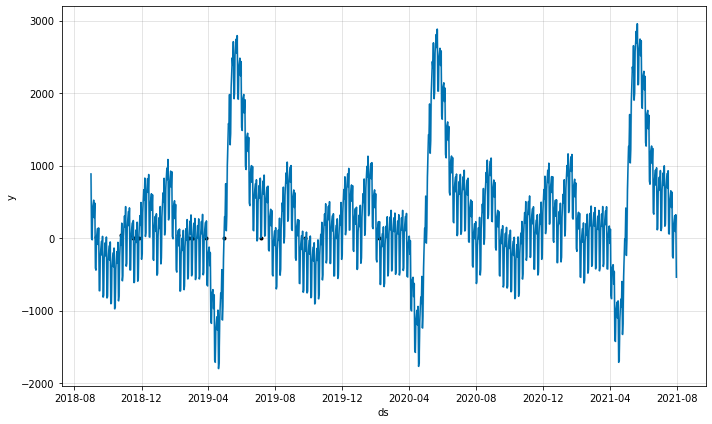

In [20]:
fig1 = mR.plot(forecastR)

# ABC Analysis


In [21]:
picking = preprocessing(p_path)
picking

,Execution_time,Amount,Order,Artikelno,Charge,Run,From_pallet,Origin,Destination,Date_receipt,Date_MHD,Recipient
0,2018-08-31,1,983500824,398,28022021,180903,114348,2-08-122-1,40,8/31/18,2/28/21,E500
1,2018-08-31,1,983500824,251,10072019,180903,114284,2-05-121-1,40,8/31/18,7/10/19,E500
2,2018-08-31,2,983500824,127,9012020,180903,114252,2-03-119-1,40,8/31/18,1/9/20,E500
3,2018-08-31,1,983500824,160,25072019,180903,114246,2-03-107-1,40,8/31/18,7/25/19,E500
4,2018-08-31,1,983500824,370,5072019,180903,114218,2-02-118-1,40,8/31/18,7/5/19,E500
...,...,...,...,...,...,...,...,...,...,...,...,...
311499,2020-07-31,27,543711,177,6012022,200731,891387,2-30-143-1,44,7/8/20,1/6/22,E33
311500,2020-07-31,8,543711,38,9062021,200731,861209,2-29-132-1,44,6/10/20,6/9/21,E33
311501,2020-07-31,17,543711,190,19122021,200731,872294,2-31-136-1,44,6/19/20,12/19/21,E33
311502,2020-07-31,21,543711,149,18042021,200731,871883,2-27-130-1,44,6/19/20,4/18/21,E33


In [22]:
time_scale = sorted(picking["Execution_time"].unique())
time_scale[-1]

numpy.datetime64('2020-07-31T00:00:00.000000000')

In [23]:
picking_sum = picking.groupby(["Artikelno"],as_index = 0)["Amount"].sum()    

<AxesSubplot:>

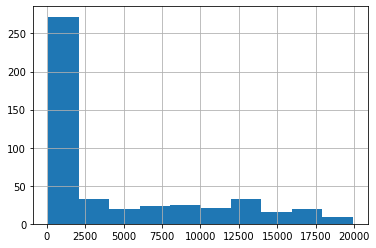

In [24]:
picking_sum[(picking_sum["Amount"]>100) & (picking_sum["Amount"]<20000)]["Amount"].hist()

In [25]:
(picking['Execution_time'].iloc[-1] + pd.DateOffset(months=12)) - pd.offsets.MonthBegin(1)

Timestamp('2021-07-01 00:00:00')

In [42]:
def ABC(data =picking.copy(),split_method="quantile", time_scale=None, ratio = (0.2,0.3,0.5),value = (0.7,0.25,0.05)):
    r'''
    ABC analysis: Split the artikels to 3 different critical type based on chosen method.
    
    Parameters:
    -------------
    data: pd.DataFrame, default=picking
        file path of picking/retrieval data
    split_method: str: {"quantile", "value", "moves"}, default= "quantile"
        file path of CLSLAB_path
    time_scale: int, default=None
        # of past months of ABC analysis, None: all history data       
    ratio: split ratio, split by quantile of the data
    value: split value, split by values of the data
    '''
    if time_scale:
        latest_date = data['Execution_time'].iloc[-1]
        start_date = latest_date - pd.DateOffset(months=time_scale) - pd.offsets.MonthBegin(1)
        data = data[data['Execution_time'] >= start_date] 
#     return data, None,None,None
    picking_sum = data.groupby(["Artikelno"],as_index = 0)["Amount"].sum()  
    picking_sort = picking_sum.sort_values(by = "Amount",ascending = False).reset_index(drop = True)
    
    N = len(picking_sort)
    All = picking_sort.copy()
    rA,rB,rC = ratio
    vA,vB,vC = value
    
    if split_method == "quantile":
        
        A,B,C = np.split(picking_sort,[int(rA*N), int((rA+rB)*N)])
    
    if split_method == "value":
        picking_value = picking_sort.copy()
        Total = picking_value.sum()["Amount"]
        
        
        picking_value["Cumsum"] = picking_value["Amount"].cumsum()
        A = picking_value[picking_value["Cumsum"]<=Total*vA]
        B = picking_value[(picking_value["Cumsum"]>Total*vA) & (picking_value["Cumsum"]<=Total*vB+Total*vA)]
        C = picking_value[picking_value["Cumsum"]>Total*vB+Total*vA]
        
        A =A[["Artikelno","Amount"]]
        B =B[["Artikelno","Amount"]]
        C =C[["Artikelno","Amount"]]
        All = All[["Artikelno","Amount"]]
    
    if split_method == "moves":
        moves = data.groupby(["Artikelno"],as_index = 0)["Amount"].agg(['count']).reset_index()
        moves_sort = moves.sort_values(by = "count",ascending = False).reset_index(drop = True)
        A,B,C = np.split(moves_sort,[int(rA*N), int((rA+rB)*N)])
        All = moves_sort.copy()
        
    
    return All, A,B,C
    

In [44]:
All_prod, A,B,C = ABC(split_method="value")

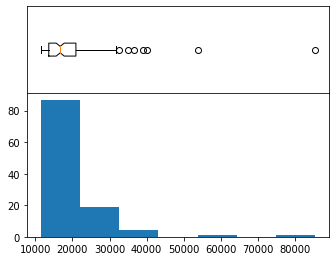

In [59]:
# setup the figure and axes
fig = plt.figure(figsize=(6,4))
bpAx = fig.add_axes([0.2, 0.7, 0.7, 0.3])   # left, bottom, width, height:
                                            # (adjust as necessary)
histAx = fig.add_axes([0.2, 0.2, 0.7, 0.5]) # left specs should match and
                                            # bottom + height on this line should
                                            # equal bottom on bpAx line
# plot stuff
bp = bpAx.boxplot(A["Amount"], notch=True, vert=False)
h = histAx.hist(A["Amount"], bins=7)

# confirm that the axes line up 
xlims = np.array([bpAx.get_xlim(), histAx.get_xlim()])
for ax in [bpAx, histAx]:
    ax.set_xlim([xlims.min(), xlims.max()])

bpAx.set_xticklabels([])  # clear out overlapping xlabels
bpAx.set_yticks([])  # don't need that 1 tick mark
plt.show()

ModuleNotFoundError: No module named 'varname'

<AxesSubplot:>

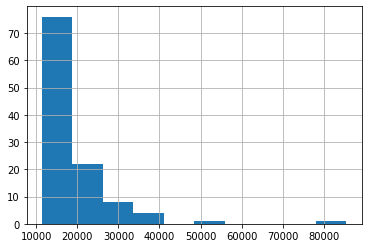

In [50]:
A["Amount"].hist()

In [28]:
All_prod

,Artikelno,count
0,118,313
1,55,306
2,60,276
3,182,262
4,106,258
...,...,...
327,1098,1
328,202,1
329,199,1
330,192,1


# Distance Matrix

In [29]:
# x:row, y:col
# horizontal 1.2, vertical 0.8

In [30]:
def dist_matrix(nx=36,ny=12,c = (-16,2),unit_h=1.2,unit_v=0.8):

    x = np.linspace(0, nx-1, nx)
    y = np.linspace(0, ny-1, ny)

    coord = np.array(np.meshgrid(x,y)).transpose([2,1,0])
#     print(coord)
    dist = np.sum(abs(coord - c)*(unit_v,unit_h),axis =2 )
    
    coord_x = coord[:,:,0].astype(int)
    coord_y = coord[:,:,1].astype(int)
    
    df =pd.DataFrame({"x":coord_x.flatten(),
                      "y":coord_y.flatten(),
                      "dist":dist.flatten()})
#     df
    return df

In [31]:
dist= dist_matrix()
dist

,x,y,dist
0,0,0,15.2
1,0,1,14.0
2,0,2,12.8
3,0,3,14.0
4,0,4,15.2
...,...,...,...
427,35,7,46.8
428,35,8,48.0
429,35,9,49.2
430,35,10,50.4


In [32]:
dist[dist["x"]==0]

,x,y,dist
0,0,0,15.2
1,0,1,14.0
2,0,2,12.8
3,0,3,14.0
4,0,4,15.2
5,0,5,16.4
6,0,6,17.6
7,0,7,18.8
8,0,8,20.0
9,0,9,21.2


In [33]:
jl

NameError: name 'jl' is not defined

# Current layout

In [ ]:
Clayout = pd.read_excel(data_path+"Current_layout.xlsx",header =None).astype(int)
Clayout.head()

In [ ]:
def Layout(distance_mat = dist.copy(),origin_layout=Clayout.copy()):
    nx = max(dist["x"])+1
    ny = max(dist["y"])+1
    layout = np.zeros([nx,ny]).astype(int)
#     print(layout.shape)
    layout[0:6,0:11]= -1
    layout[:,[1,4,7,10]]= -1
    distance_mat["layout"] = layout.flatten()
    distance_mat["Clayout"] = Clayout.to_numpy().flatten()
    return distance_mat

In [ ]:
layout_mat = Layout()
layout_mat

In [ ]:
def model_input(All = All_prod.copy(),origin_layout=Clayout.copy()):
    unique, counts = np.unique(Clayout.to_numpy().flatten(), return_counts=True)
    model_in = All.merge(pd.DataFrame({"Artikelno":unique, "storage":counts}), on = "Artikelno",how="left").fillna(1)
    model_in["moves_p"] = model_in["count"]/model_in["storage"]
    model_in = model_in.sort_values(by = "moves_p",ascending = False).reset_index(drop = True)
    return model_in

In [ ]:
model_in=model_input()
model_in

In [ ]:
layout_mat.sort_values(by="dist")

In [ ]:
def heurist_layout(layout = layout_mat.copy() ,model_in = model_in.copy()):
    output = layout.sort_values(by = "dist",ascending = True)
#     print(len(output[output["layout"]!=-1])

    ava_cell = len(output[output["layout"]!=-1]) 
    num_items = len(model_in["Artikelno"])
    if ava_cell< num_items:
#         print(output.loc[output["layout"]!=-1,:])
        output.loc[output["layout"]!=-1, "layout"] = model_in["Artikelno"][:ava_cell].to_numpy()
#         print(output.loc[output["layout"]!=-1, "layout"])
    else:
        output.loc[output["layout"]!=-1, "layout"][:num_items] = model_in["Artikelno"].to_numpy()
    
    output = output.sort_values(by = ["x","y"],ascending = True).reset_index(drop = True)
    return output

In [ ]:
output = heurist_layout()
output

In [ ]:

output.layout.astype(int).to_numpy().reshape(36,12)